In [1]:
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, Date, Float
from sqlalchemy import func,text
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.exc import SQLAlchemyError
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date

#### Connect to database

In [2]:
Server   = "KHUONGPD\SQLEXPRESS"
Database = "PE_Demo_S2019"
UID      = "KhuongPD\khuon"
# PWD      = "<Replace with password if needed>"

# SQLAlchemy connection URL
connection_url = (f"mssql+pyodbc://{UID}@{Server}/{Database}"
                  "?driver=ODBC+Driver+17+for+SQL+Server"
                  "&trusted_connection=yes")

# Nếu cần sử dụng username và password:
# connection_url = (f"mssql+pyodbc://{UID}:{PWD}@{Server}/{Database}"
#                   "?driver=ODBC+Driver+17+for+SQL+Server")

# Tạo engine với URL kết nối
engine = create_engine(connection_url)

# Tạo session factory
Session = sessionmaker(bind=engine)

# Thử kết nối
try:
    # Tạo session
    session = Session()
    print("Connected to SQL database Server:", Server, "\nDatabase:", Database)
except Exception as ex:
    print("Unable to connect:", str(ex))
finally:
    # Đóng session
    session.close()

Connected to SQL database Server: KHUONGPD\SQLEXPRESS 
Database: PE_Demo_S2019


#### Database's Diagram

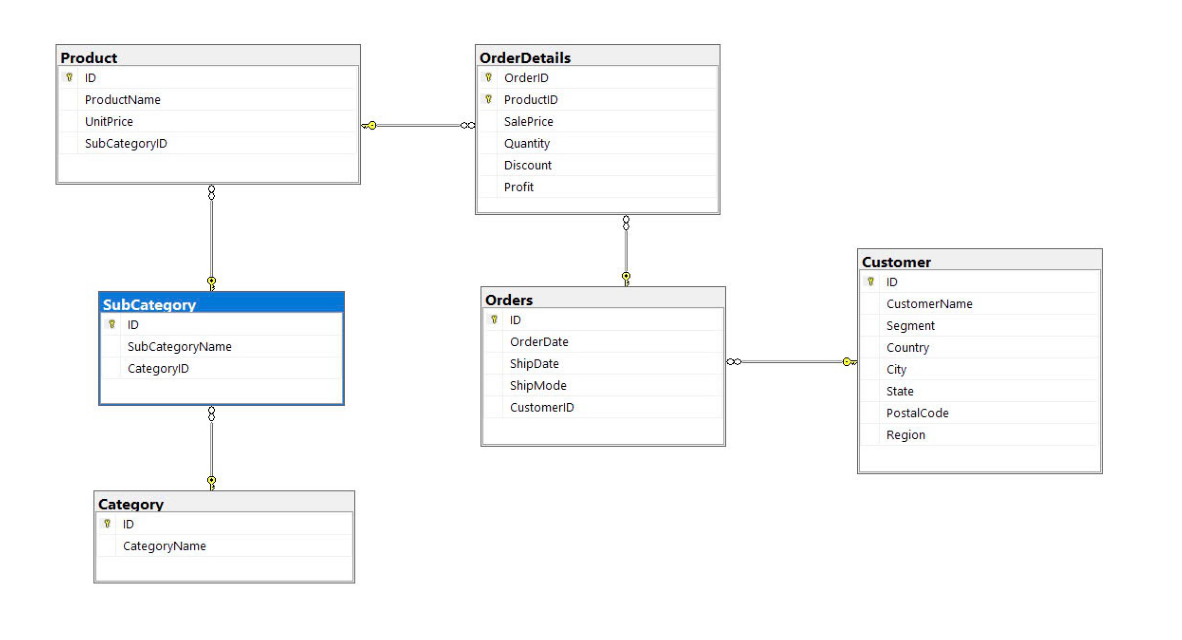

In [3]:
img = Image.open('Diagram.jpg')
plt.figure(figsize=(15, 15)) 
plt.imshow(img)
plt.axis('off')
plt.show()

#### Tạo các class là các bảng, mỗi thuộc tính của class là một cột trong bảng

In [4]:
Base = declarative_base()

class Category(Base):
    __tablename__ = 'Category'
    ID = Column(Integer, primary_key=True)
    CategoryName = Column(String)

class SubCategory(Base):
    __tablename__ = 'SubCategory'
    ID = Column(Integer, primary_key=True)
    SubCategoryName = Column(String)
    CategoryID = Column(Integer, ForeignKey('Category.ID'))
    category = relationship("Category", back_populates="subcategories")

Category.subcategories = relationship("SubCategory", order_by=SubCategory.ID, back_populates="category")

class Product(Base):
    __tablename__ = 'Product'
    ID = Column(Integer, primary_key=True)
    ProductName = Column(String)
    UnitPrice = Column(Float)
    SubCategoryID = Column(Integer, ForeignKey('SubCategory.ID'))
    subcategory = relationship("SubCategory", back_populates="products")

SubCategory.products = relationship("Product", order_by=Product.ID, back_populates="subcategory")

class Customer(Base):
    __tablename__ = 'Customer'
    ID = Column(Integer, primary_key=True)
    CustomerName = Column(String)
    Segment = Column(String)
    Country = Column(String)
    City = Column(String)
    State = Column(String)
    PostalCode = Column(Integer)
    Region = Column(String)

class Orders(Base):
    __tablename__ = 'Orders'
    ID = Column(String, primary_key=True)
    OrderDate = Column(Date)
    ShipDate = Column(Date)
    ShipMode = Column(String)
    CustomerID = Column(Integer, ForeignKey('Customer.ID'))
    customer = relationship("Customer", back_populates="orders")

Customer.orders = relationship("Orders", order_by=Orders.ID, back_populates="customer")

class OrderDetails(Base):
    __tablename__ = 'OrderDetails'
    OrderID = Column(String, ForeignKey('Orders.ID'), primary_key=True)
    ProductID = Column(Integer, ForeignKey('Product.ID'), primary_key=True)
    SalePrice = Column(Float)
    Quantity = Column(Integer)
    Discount = Column(Float)
    Profit = Column(Float)
    order = relationship("Orders", back_populates="orderdetails")
    product = relationship("Product", back_populates="orderdetails")

Orders.orderdetails = relationship("OrderDetails", order_by=OrderDetails.OrderID, back_populates="order")
Product.orderdetails = relationship("OrderDetails", order_by=OrderDetails.ProductID, back_populates="product")

C:\Users\khuon\AppData\Local\Temp\ipykernel_23968\807360439.py:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


#### Subquery _ Tính giá trị lợi nhuận trung bình một sản phẩm mang lại _ Tổng hợp theo nhiều giai đoạn

In [5]:
# Tổng lợi nhuận
Unit_count = session.query(func.sum(Product.UnitPrice)).scalar()
print(f"Number of customers: {Unit_count}")

# Tổng số lượng sản phẩm
total_quantity = session.query(func.sum(OrderDetails.Quantity)).scalar()
print(f"Total quantity of products ordered: {total_quantity}")

# Tính giá trị lợi nhuận trung bình một sản phẩm mang lại
average_price = session.query(Unit_count/total_quantity).scalar()
print(f"Average unit price: {average_price}")

Number of customers: 113252.28610000014
Total quantity of products ordered: 37792
Average unit price: 2.9967264526884034


#### Xử lý câu lệnh thuần text _ Sử dụng subquery để tìm các khách hàng có số lượng sản phẩm đặt hàng lớn hơn số lượng trung bình 

In [6]:
customer_product = session.execute(text('''
with CustomerCountProduct as (
    select o.CustomerID, count(od.ProductID) as TotalProduct
    from Orders as o
    join OrderDetails as od on o.ID = od.OrderID
    group by o.CustomerID
),

AvgProductCount as (
    select AVG(TotalProduct) as AvgProduct
    from CustomerCountProduct
)

select CustomerID, TotalProduct
from CustomerCountProduct, AvgProductCount
where TotalProduct > AvgProduct
order by TotalProduct asc
'''))

result = customer_product.fetchall()
_df = pd.DataFrame(result, columns=customer_product.keys())
_df

,CustomerID,TotalProduct
0,3581,3
1,2894,3
2,1520,3
3,1420,3
4,2107,3
...,...,...
1265,3674,11
1266,4858,11
1267,4446,12
1268,230,12


#### Sử dụng subquery với UNION

In [7]:
#tìm những sản phẩm thuộc subcategoryID là 1 và 3
sub1 = session.query(Product).filter_by(SubCategoryID = 1)
sub2 = session.query(Product).filter_by(SubCategoryID = 3)
result_ = sub1.union(sub2)

result = result_.all()    
session.close()

data = []
for i in result:
    data.append({
        "ID": i.ID,
        "ProductName": i.ProductName,
        "UnitPrice" : i.UnitPrice,
        "SubCategoryID":i.SubCategoryID
    })
df0 = pd.DataFrame(data)
df0

,ID,ProductName,UnitPrice,SubCategoryID
0,1,"""While you Were Out"" Message Book, One Form pe...",1.8550,3
1,10,1/4 Fold Party Design Invitations & White Enve...,3.8955,3
2,11,12 Colored Short Pencils,1.8980,1
3,13,14-7/8 x 11 Blue Bar Computer Printout Paper,24.9808,3
4,28,4009 Highlighters,0.8844,1
...,...,...,...,...
429,1837,Xerox 232,3.3696,3
430,1838,Xerox 4200 Series MultiUse Premium Copy Paper ...,2.9040,3
431,1839,Xerox Blank Computer Paper,10.5894,3
432,1840,"Xerox Color Copier Paper, 11"" x 17"", Ream",12.3336,3


#### Sử dụng session để quản lý các transaction, các transaction được commit nếu thực hiện thành công và roll back nếu như xảy ra lỗi.

In [8]:
qr = """Select * from Category"""
d = pd.read_sql(qr,connection_url)
d

,ID,CategoryName
0,1,Office Supplies
1,2,Furniture
2,3,Technology
3,4,Electronics
4,5,Electronics
5,6,Electronics
6,7,Electronics
7,8,Transport
8,9,Toy


In [9]:
session1 = Session()
try:
    # Thực hiện các thao tác với database trong session1
    new_category = Category(CategoryName='Toy')
    session1.add(new_category)
    session1.commit()
    print("Transaction 1 committed")
except SQLAlchemyError as e:
    session1.rollback()
    print(f"Transaction 1 failed: {e}")
finally:
    session1.close()

query1 = """
select * from Category where CategoryName='Toy'"""
df1 = pd.read_sql(query1, connection_url)
df1

Transaction 1 committed


,ID,CategoryName
0,9,Toy
1,10,Toy


In [10]:
session2 = Session()
try:
    # Thực hiện các thao tác với database trong session2
    new_customer = Customer(CustomerName='Khuong', Segment='Consumer', Country='VietNam', City='Ha Noi', State='Son Tay', PostalCode='12345', Region='West')
    session2.add(new_customer)
    session2.commit()
    print("Transaction 2 committed")
except SQLAlchemyError as e:
    session2.rollback()
    print(f"Transaction 2 failed: {e}")
finally:
    session2.close()

query2 = """Select * from Customer where CustomerName = 'Khuong'"""
df2 = pd.read_sql(query2, connection_url)
df2

Transaction 2 committed


,ID,CustomerName,Segment,Country,City,State,PostalCode,Region
0,4922,Khuong,Consumer,VietNam,Ha Noi,Son Tay,12345.0,West
1,4924,Khuong,Consumer,VietNam,Ha Noi,Son Tay,12345.0,West


In [11]:
qr_ = """Select * from Orders"""
d_ = pd.read_sql(qr_,connection_url)
d_.dtypes

ID                    object
OrderDate     datetime64[ns]
ShipDate      datetime64[ns]
ShipMode              object
CustomerID           float64
dtype: object

In [12]:
session3 = Session()
try:
    # Thực hiện các thao tác với database trong session3
    new_order = Orders(OrderDate='2023-08-02', ShipDate='2023-08-05', ShipMode='Standard', CustomerID=new_customer.ID) 
    # Xảy ra lỗi do OrderDate='2023-08-02', ShipDate='2023-08-05'truyền vào kiểu dữ liệu string
    session3.add(new_order)
    session3.commit()  # Commit transaction
    print("Transaction 3 committed")
except SQLAlchemyError as e:
    session3.rollback()  # Rollback nếu có lỗi
    print(f"Transaction 3 failed: {e}")
finally:
    session3.close()

Transaction 3 failed: Instance <Customer at 0x2419394c910> is not bound to a Session; attribute refresh operation cannot proceed (Background on this error at: https://sqlalche.me/e/20/bhk3)


#### Các thao tác như INSERT, UPDATE, DELETE,... được coi là transaction riêng lẻ

In [13]:
# Xử lý câu lệnh thuần
query = """
select * from Customer where CustomerName='Gary Zandusky'"""
import pandas as pd
df = pd.read_sql(query, connection_url)
df

,ID,CustomerName,Segment,Country,City,State,PostalCode,Region
0,1827,Gary Zandusky,Consumer,United States,HaNoi,Virginia,22204.0,South
1,1828,Gary Zandusky,Consumer,United States,Bullhead City,Arizona,86442.0,West
2,1829,Gary Zandusky,Consumer,United States,Columbia,Maryland,21044.0,East
3,1830,Gary Zandusky,Consumer,United States,Morristown,New Jersey,7960.0,East
4,1831,Gary Zandusky,Consumer,United States,Rio Rancho,New Mexico,87124.0,West
5,1832,Gary Zandusky,Consumer,United States,Rochester,Minnesota,55901.0,Central
6,1833,Gary Zandusky,Consumer,United States,San Francisco,California,94109.0,West
7,1835,Gary Zandusky,Consumer,United States,Texas City,Texas,77590.0,Central


In [14]:
# Thao tác update
customer = session.query(Customer).filter_by(CustomerName='Gary Zandusky').first()
if customer:
    customer.City = 'HaNoi'
    session.commit()

query_ = """select * from Customer where CustomerName='Gary Zandusky'"""

import pandas as pd
df_ = pd.read_sql(query_, connection_url)
df_

,ID,CustomerName,Segment,Country,City,State,PostalCode,Region
0,1827,Gary Zandusky,Consumer,United States,HaNoi,Virginia,22204.0,South
1,1828,Gary Zandusky,Consumer,United States,Bullhead City,Arizona,86442.0,West
2,1829,Gary Zandusky,Consumer,United States,Columbia,Maryland,21044.0,East
3,1830,Gary Zandusky,Consumer,United States,Morristown,New Jersey,7960.0,East
4,1831,Gary Zandusky,Consumer,United States,Rio Rancho,New Mexico,87124.0,West
5,1832,Gary Zandusky,Consumer,United States,Rochester,Minnesota,55901.0,Central
6,1833,Gary Zandusky,Consumer,United States,San Francisco,California,94109.0,West
7,1835,Gary Zandusky,Consumer,United States,Texas City,Texas,77590.0,Central


In [15]:
# Thao tác xoá (Delete)
delete_customer = session.query(Customer).filter_by(ID = 1834).first()
if delete_customer:
    session.delete(delete_customer)
    session.commit()

query__ = """
select * from Customer where CustomerName='Gary Zandusky'"""
import pandas as pd
df__ = pd.read_sql(query__, connection_url)
df__

,ID,CustomerName,Segment,Country,City,State,PostalCode,Region
0,1827,Gary Zandusky,Consumer,United States,HaNoi,Virginia,22204.0,South
1,1828,Gary Zandusky,Consumer,United States,Bullhead City,Arizona,86442.0,West
2,1829,Gary Zandusky,Consumer,United States,Columbia,Maryland,21044.0,East
3,1830,Gary Zandusky,Consumer,United States,Morristown,New Jersey,7960.0,East
4,1831,Gary Zandusky,Consumer,United States,Rio Rancho,New Mexico,87124.0,West
5,1832,Gary Zandusky,Consumer,United States,Rochester,Minnesota,55901.0,Central
6,1833,Gary Zandusky,Consumer,United States,San Francisco,California,94109.0,West
7,1835,Gary Zandusky,Consumer,United States,Texas City,Texas,77590.0,Central


#### Batch scoped Transaction

In [16]:
try:
    with session.begin():  # Bắt đầu giao dịch
        # Thực hiện các thao tác trong batch
        # Thêm một khách hàng
        new_customer_ = Customer(
            CustomerName='Hieu',
            Segment='Consumer',
            Country='VietNam',
            City='Ha Noi',
            State='Ba Dinh',
            PostalCode='12344',
            Region='Center'
        )  # Thêm một customer
        session.add(new_customer_)
        session.flush()  # Flush để gán giá trị ID cho new_customer_

        # Thêm đơn hàng
        new_order_detail1 = Orders(
            ID='CA-2014-999999',
            OrderDate=date(2024, 8, 5),
            ShipDate=date(2024, 8, 7),
            ShipMode='Standard',
            CustomerID=new_customer_.ID
        )
        new_order_detail2 = Orders(
            ID='CA-2014-888888',
            OrderDate=date(2024, 8, 5),
            ShipDate=date(2024, 8, 10),
            ShipMode='Standard',
            CustomerID=new_customer_.ID
        )

        session.add(new_order_detail1)
        session.add(new_order_detail2)

except SQLAlchemyError as e:
    print(f"Error: {e}")
    session.rollback()  # Đảm bảo rollback nếu có lỗi

finally:
    session.close()

Error: A transaction is already begun on this Session.


In [17]:
check = """Select * from Orders where ID='CA-2014-999999' or ID='CA-2014-888888'"""
c = pd.read_sql(check, connection_url)
c

,ID,OrderDate,ShipDate,ShipMode,CustomerID
0,CA-2014-888888,2024-08-05,2024-08-10,Standard,4923
1,CA-2014-999999,2024-08-05,2024-08-07,Standard,4923


### Deadlock

In [18]:
a = """Select * from Customer where ID = 4921"""
b = """Select * from Orders where ID = 'CA-2014-100000'"""
a_ = pd.read_sql(a,connection_url)
b_ = pd.read_sql(b,connection_url)

In [19]:
a_ #select từ bảng Customer

,ID,CustomerName,Segment,Country,City,State,PostalCode,Region
0,4921,hieu,Consumer,VietNam,Ha Noi,Son Tay,12344.0,Center


In [20]:
b_ #Select từ bảng Orders

,ID,OrderDate,ShipDate,ShipMode,CustomerID
0,CA-2014-100000,2024-08-05,2024-08-07,Standard,4921


In [21]:
import time
import threading

#### Tạo 2 transaction, transaction này sẽ khoá tài nguyên theo thứ tự ngược lại với transaction kia

In [22]:
session1 = Session()
session2 = Session()
def transaction1():
    try:
        with session1.begin():
            print("Transaction 1: Khóa Orders")
            order = session1.query(Orders).filter_by(ID='CA-2014-100000').with_for_update().first()
            print("Transaction 1: Đã khóa Orders")
            time.sleep(10)  # Mô phỏng độ trễ
            print("Transaction 1: Khóa Customer")
            customer = session1.query(Customer).filter_by(ID=4921).with_for_update().first()
            print("Transaction 1: Đã khóa Customer")
    except SQLAlchemyError as e:
        print(f"Transaction 1 Lỗi: {e}")
        session1.rollback()
    finally:
        session1.close()

def transaction2():
    try:
        with session2.begin():
            print("Transaction 2: Khóa Customer")
            customer = session2.query(Customer).filter_by(ID=4921).with_for_update().first()
            print("Transaction 2: Đã khóa Customer")
            time.sleep(10)  # Mô phỏng độ trễ
            print("Transaction 2: Khóa Orders")
            order = session2.query(Orders).filter_by(ID='CA-2014-100000').with_for_update().first()
            print("Transaction 2: Đã khóa Orders")
    except SQLAlchemyError as e:
        print(f"Transaction 2 Lỗi: {e}")
        session2.rollback()
    finally:
        session2.close()

thread1 = threading.Thread(target=transaction1)
thread2 = threading.Thread(target=transaction2)

thread1.start()
thread2.start()

thread1.join()
thread2.join()

Transaction 1: Khóa Orders
Transaction 2: Khóa Customer
Transaction 1: Đã khóa Orders
Transaction 2: Đã khóa Customer
Transaction 2: Khóa Orders
Transaction 1: Khóa Customer
Transaction 2: Đã khóa Orders
Transaction 1: Đã khóa Customer


#### Lúc này, transaction 1 và 2 đang đợi nhau, tài nguyên lúc này chưa được giải phóng. Ta thử thực hiện 1 thao tác update lên tài nguyên ở bảng Customer.

In [23]:
# Ban đầu
a_

,ID,CustomerName,Segment,Country,City,State,PostalCode,Region
0,4921,hieu,Consumer,VietNam,Ha Noi,Son Tay,12344.0,Center


In [24]:
customer_update = session.query(Customer).filter_by(ID = 4921)
if customer_update:
    customer_update.City = 'Ba Đình'
    customer_update.CustomerName = 'Hieu'
    session.commit()

c = """Select * from Customer where ID = 4921"""
c_ = pd.read_sql(c,connection_url)
c_

,ID,CustomerName,Segment,Country,City,State,PostalCode,Region
0,4921,hieu,Consumer,VietNam,Ha Noi,Son Tay,12344.0,Center


=> Như vậy là không update thành công do tài nguyên lúc này chưa được giải phóng

#### Xử lý deadlock với Wait-Die Scheme và Wound-Wait Scheme

In [1]:
def cancel_transactions():
    try:
        print("Cancelling all transactions...")
        session1.rollback()
        session2.rollback()
    finally:
        session1.close()
        session2.close()

cancel_transactions()
thread1.join()
thread2.join()

Cancelling all transactions...


NameError: name 'session1' is not defined

In [ ]:
# Wait-Die Scheme
def wait_die_scheme(t1_id, t2_id):
    if t1_id < t2_id:
        print(f"Transaction {t1_id} waits for Transaction {t2_id}")
        return "wait"
    else:
        print(f"Transaction {t2_id} dies (Transaction {t1_id} is older)")
        return "die"

# Kiểm tra giao thức Wait-Die trước khi bắt đầu
decision = wait_die_scheme(1, 2)

if decision == "wait":
    thread1 = threading.Thread(target=transaction1)
    thread2 = threading.Thread(target=transaction2)

    thread1.start()
    thread2.start()

    thread1.join()
    thread2.join()
elif decision == "die":
    print("Transaction 2 bị hủy theo giao thức Wait-Die")
    thread1 = threading.Thread(target=transaction1)
    thread1.start()
    thread1.join()